# Train Flowers Classification using ResNet50

In [1]:
# Imports
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Auxiliary Functions

In [2]:
# Get all data from a directory and return as a dataframe
def get_dataset(folder_path):
    folder = Path(folder_path)

    filepaths = list(folder.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    return pd.concat([filepaths, labels], axis=1)

# Split dataframe into train and validation
def split_train_and_test(dataset):
    # Split the dataset into features (X) and labels/classes (y)
    X = dataset['Filepath']
    y = dataset['Label']

    # Get the unique labels/classes in the dataset
    classes = y.unique()

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Split the dataset based on classes
    for class_label in classes:
        # Filter samples belonging to each class
        class_samples = dataset[dataset['Label'] == class_label]
        
        # Split the samples into train and test sets
        train_samples, test_samples = train_test_split(class_samples, test_size=0.2, random_state=42)
        
        # Add the split samples to the train and test sets
        train_data = pd.concat([train_data, train_samples])
        test_data = pd.concat([test_data, test_samples])

    print("Training set:")
    print("Quantity of samples:", len(train_data))
    print("Quantity of classes:", len(train_data['Label'].unique()))
    print()

    print("Test set:")
    print("Quantity of samples:", len(test_data))
    print("Quantity of classes:", len(test_data['Label'].unique()))
    
    return train_data, test_data

# Read images from dataset and display one
def read_and_display_images(dataset):
    # Get the unique classes in the dataset
    classes = dataset['Label'].unique()

    fig, axs = plt.subplots(1, len(classes), figsize=(12, 6))

    for i, class_label in enumerate(classes):
        # Filter samples belonging to each class
        class_samples = dataset[dataset['Label'] == class_label]
        
        # Select a random image from the class
        image_path = class_samples['Filepath'].sample(1).iloc[0]
        
        # Read the image in RGB format
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Convert the color channel from BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Display the image in the corresponding subplot
        axs[i].imshow(image_rgb)
        axs[i].set_title(class_label)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load Images into Dataframe

In [3]:
# Read images from directory
folder_path = './flowers/'
dataset = get_dataset(folder_path)
dataset

,Filepath,Label
0,flowers\daisy\100080576_f52e8ee070_n.jpg,daisy
1,flowers\daisy\10140303196_b88d3d6cec.jpg,daisy
2,flowers\daisy\10172379554_b296050f82_n.jpg,daisy
3,flowers\daisy\10172567486_2748826a8b.jpg,daisy
4,flowers\daisy\10172636503_21bededa75_n.jpg,daisy
...,...,...
4312,flowers\tulip\9831362123_5aac525a99_n.jpg,tulip
4313,flowers\tulip\9870557734_88eb3b9e3b_n.jpg,tulip
4314,flowers\tulip\9947374414_fdf1d0861c_n.jpg,tulip
4315,flowers\tulip\9947385346_3a8cacea02_n.jpg,tulip


In [4]:
# Disinct labels and count
dataset['Label'].value_counts()

dandelion    1052
tulip         984
rose          784
daisy         764
sunflower     733
Name: Label, dtype: int64

# Split Train and Validation

In [5]:
# Split dataset
train, test = split_train_and_test(dataset)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

Training set:
Quantity of samples: 3452
Quantity of classes: 5

Test set:
Quantity of samples: 865
Quantity of classes: 5


In [6]:
train['Label'].value_counts()

dandelion    841
tulip        787
rose         627
daisy        611
sunflower    586
Name: Label, dtype: int64

In [7]:
test['Label'].value_counts()

dandelion    211
tulip        197
rose         157
daisy        153
sunflower    147
Name: Label, dtype: int64

# Check Shape of Image (RGB or Gray Scale)

In [8]:
# Read image
image = cv2.imread('./flowers/daisy/5547758_eea9edfd54_n.jpg')

# Check shape
if(len(image.shape) < 3):
    print('Gray Scale')
elif len(image.shape) == 3:
    print('RGB')
else:
    print('Others')

RGB


# Image Visualization

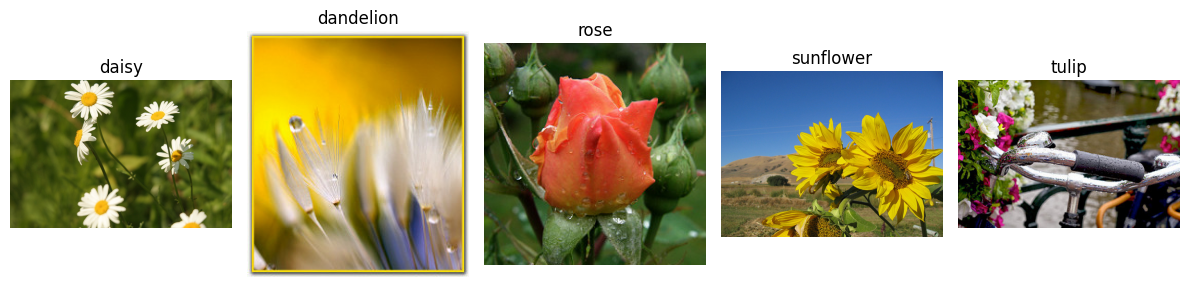

In [9]:
# Show example of each class
read_and_display_images(dataset)

# Shuffle Images

In [9]:
# Shuffle images to avoid order bias
train_data = train.sample(frac=1).reset_index(drop=True)
test_data = test.sample(frac=1).reset_index(drop=True)

# DataBlock of Images

In [10]:
# Params
image_size = 224
color_mode='rgb'
batch_size=32

# Datablock generator for images
generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# Create datablock of train images
train_images = generator.flow_from_dataframe(
    dataframe=train_data,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    seed=42
)

# Create datablock of validation images
validation_images = generator.flow_from_dataframe(
    dataframe=test_data,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    seed=42
)

# Print classes
print("Train classes:", train_images.class_indices)
print("Validation classes:", validation_images.class_indices)

Found 3452 validated image filenames belonging to 5 classes.
Found 865 validated image filenames belonging to 5 classes.
Train classes: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Validation classes: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


# Create ResNet50 Model

In [11]:
# Define number of classes
num_classes = len(dataset['Label'].unique())

# Create the neural network model
def convolutional_model(base_model, device):
    with tf.device(device):
        model = Sequential(name='sequential')
        model.add(base_model)
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(num_classes, activation='softmax'))

        # Compile the model
        optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

        # Print a summary of the model architecture
        model.summary()

        return model
    
# Load the ResNet50 model without the fully connected layers
base_model = ResNet50(weights='imagenet', pooling='avg', include_top=False)

# Freeze the weights of the base model to avoid training during fine-tuning
base_model.trainable = False

# Define GPU or CPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    if tf.test.gpu_device_name():
        print("GPU is available.")
        device = 'DML'
    else:
        print("GPU is not available. Using CPU.")
        device = 'CPU'

# Create ResNet50 model using AMD GPU
resnet50_model = convolutional_model(base_model, device)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


GPU is available.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_____________________

# Model Callbacks

In [60]:
# Save best model and create early stop
cb_checkpointer = ModelCheckpoint(filepath='./best_model.hdf5', save_weights_only=False, monitor='val_acc', save_best_only=True, mode='max', verbose=1)

# Fit Model

In [61]:
# Fit model with train and validation, and add callbacks
step_size_train = train_images.n//train_images.batch_size
step_size_validation = validation_images.n//validation_images.batch_size

resnet50_model.fit_generator(
    train_images,
    validation_data=validation_images,
    epochs=50,
    callbacks=[cb_checkpointer],
    validation_steps=step_size_validation,
    steps_per_epoch=step_size_train
)

Epoch 1/50
 27/107 [======>.......................] - ETA: 30s - loss: 0.6700 - acc: 0.7905
Epoch 00001: val_acc improved from -inf to 0.79051, saving model to ./best_model.hdf5
107/107 [==============================] - 79s 736ms/step - loss: 0.7393 - acc: 0.7307 - val_loss: 0.6700 - val_acc: 0.7905
Epoch 2/50
 27/107 [======>.......................] - ETA: 14s - loss: 0.7205 - acc: 0.8113
Epoch 00002: val_acc improved from 0.79051 to 0.81134, saving model to ./best_model.hdf5
107/107 [==============================] - 30s 285ms/step - loss: 0.4435 - acc: 0.8395 - val_loss: 0.7205 - val_acc: 0.8113
Epoch 3/50
 27/107 [======>.......................] - ETA: 14s - loss: 0.6692 - acc: 0.7975
Epoch 00003: val_acc did not improve from 0.81134
107/107 [==============================] - 30s 281ms/step - loss: 0.3473 - acc: 0.8740 - val_loss: 0.6692 - val_acc: 0.7975
Epoch 4/50
 27/107 [======>.......................] - ETA: 14s - loss: 0.6697 - acc: 0.8113
Epoch 00004: val_acc did not improv

# Load Model

In [12]:
# Load best model fit
resnet50_model.load_weights('./best_model.hdf5')

# Evaluating Model

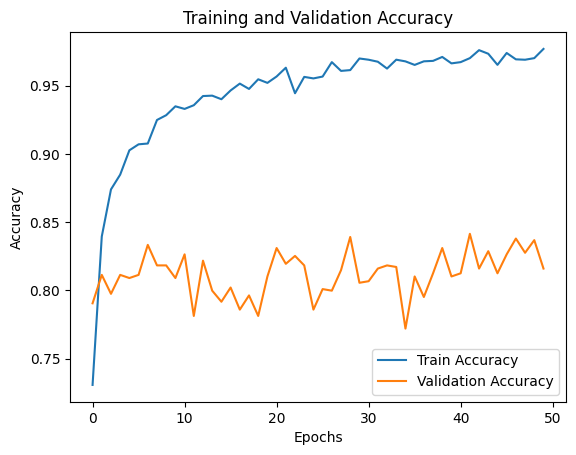

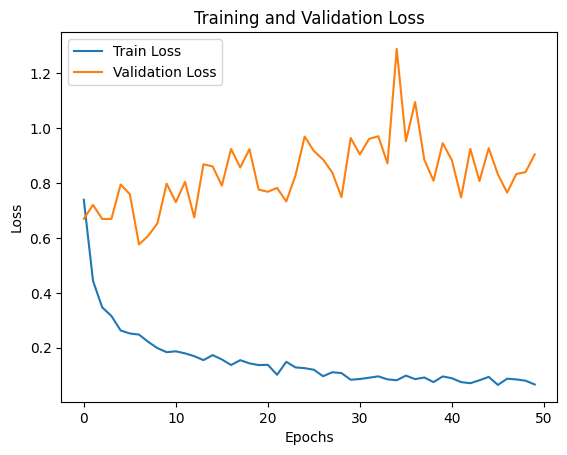

In [63]:
# Get training metrics
train_accuracy = resnet50_model.history.history['acc']
train_loss = resnet50_model.history.history['loss']

# Get validation metrics
val_accuracy = resnet50_model.history.history['val_acc']
val_loss = resnet50_model.history.history['val_loss']

# Create accuracy plot
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Create loss plot
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Model accuracy
num_samples = len(validation_images.filenames)
_, accuracy = resnet50_model.evaluate_generator(validation_images, steps=num_samples // validation_images.batch_size)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

Accuracy: 84.14%


# Test for One Image

In [72]:
# Load the image
image_path = './flowers/tulip/10791227_7168491604.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = np.expand_dims(image, axis=0)

# Preprocess the image
image = preprocess_input(image)

# Prediction
predictions = resnet50_model.predict(image)

# Interpret the predictions
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
predicted_class = np.argmax(predictions[0])
predicted_label = class_names[predicted_class]

# Calculate prediction accuracy
accuracy = predictions[0][predicted_class]

print('Prediction:', predicted_label)
print(f'Accuracy: {round(accuracy * 100, 2)}%')

Prediction: tulip
Accuracy: 99.97%


# Model Architecture

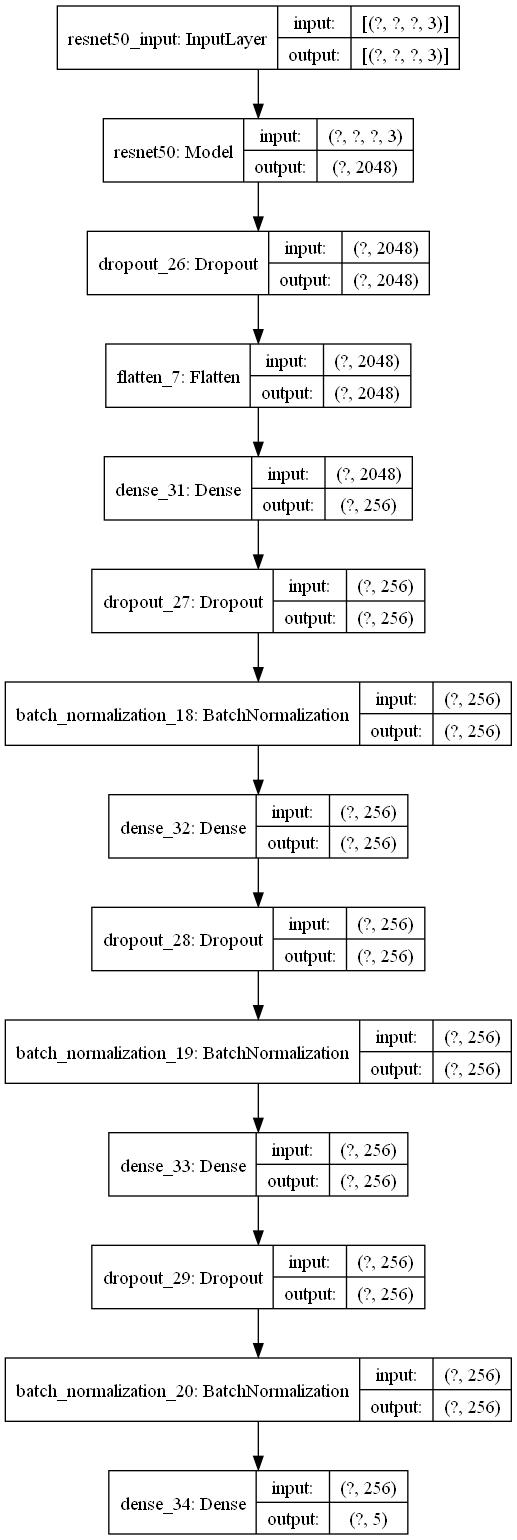

In [65]:
img_file = './model_architecture.png'

tf.keras.utils.plot_model(resnet50_model, to_file=img_file, show_shapes=True, show_layer_names=True)